<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a2_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1: Kaiting Liu

# Student 2: Sihan Zhu

# Student 3: Ruozhu Yao

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [3]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']
    
positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [4]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0] 

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.05159559 -1.46130851].
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [5]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [6]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

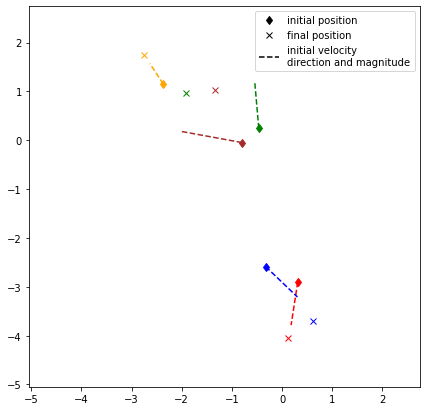

In [7]:
random_idx = np.random.randint(0, 10000)
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [ ]:
#todo

In [8]:
import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
from PIL import Image

def data_transformation(positions, velocities, charges):
    """
    Transform the original set of 6 images to the set of 3 images, 
    (anchor, support image has same character, support image has different character)
    """
    positions_start = positions[:, 0, :, :]
    velocities_start = velocities[:, 0, :, :]
    charges_start = charges[:, :, :]

    temp = np.concatenate((positions_start, velocities_start), axis=1)
    temp = np.moveaxis(temp, 1, 2)
    input_data = np.concatenate((temp,charges_start), axis=2)

    positions_end = np.moveaxis(positions, 2, 3)
    label_data_1 = positions_end[:, 1, :, :]
    label_data_2 = positions_end[:, 2, :, :]
    label_data_3 = positions_end[:, 3, :, :]

    return input_data, label_data_1, label_data_2, label_data_3

class MyDataset(Dataset):
    def __init__(self, input_data, label_data):
        self.input_data = torch.FloatTensor(input_data)
        self.label_data = torch.FloatTensor(label_data)
        
    def __getitem__(self, index):
        input = self.input_data[index, :, :]
        label = self.label_data[index, :, :]
        return input, label
        
    def __len__(self):
        return len(self.label_data)

# Model Implementation

In [ ]:
#todo

In [74]:
## Model Definition ##
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        """Embedding extraction, use aggregation function here to utilize neighborhood info""" 
        self.embedding = nn.Sequential(nn.Linear(10, 5), nn.BatchNorm1d(5,momentum=1,affine=True), nn.Sigmoid())

        """Multilayer Perceptron."""
        self.MLP = nn.Sequential(
            nn.Linear(5, 32),
            nn.BatchNorm1d(32,momentum=1,affine=True),
            nn.ReLU(inplace=True),  
            nn.Linear(32, 32),
            nn.BatchNorm1d(32,momentum=1,affine=True),
            nn.ReLU(inplace=True),  
            nn.Linear(32, 2)
        )

    def aggregate(self, x, neighbors):
        """aggregate the info of set for x"""
        neighbors_info = torch.mean(neighbors, axis=1)
        return torch.concat((x,neighbors_info), axis=1)

    def forward(self, input):
        """Perform forward"""
        positions = []
        for idx in range(5):
          aggregation = self.aggregate(input[:, idx, :], np.delete(input, idx, axis=1))
          embedding = self.embedding(aggregation)
          position = self.MLP(embedding)
          positions.append(position)
        positions = torch.stack(positions)
        positions = torch.moveaxis(positions, 0, 1)
        return positions

    def predict(self, input):
        """Perform forward"""
        positions = []
        for idx in range(5):
          aggregation = self.aggregate(input[:, idx, :], np.delete(input, idx, axis=1))
          embedding = self.embedding(aggregation)
          position = self.MLP(embedding)
          positions.append(position)
        positions = torch.stack(positions)
        positions = torch.moveaxis(positions, 0, 1)
        return positions


    def accuracy(self, batch):
      """
      using full accuracy to evaluate our model performance, 
      by predicting one set is correct when all the images in the set is predicted correctly.
      """
      inputs, labels = batch
      predictions = self.predict(inputs)
      cos = nn.CosineSimilarity(dim=2, eps=1e-6)
      cos_sims = cos(predictions, labels)
      return cos_sims.mean()



In [75]:
## LOSS Definition ##
class MSELoss(nn.Module):
    """
    Mean squared loss
    """

    def __init__(self):
        super(MSELoss, self).__init__()

    def forward(self, prediction, label):
        error = prediction - label
        squared_error = torch.square(error)
        losses = torch.sum(squared_error)
        return losses.mean()

# Model Training

In [ ]:
#todo

In [97]:
import numpy as np
from tqdm import tqdm

class Trainer():
    def __init__(self,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 epochs: int
                 ):

        self.criterion = criterion
        self.device = device
        self.epochs = epochs


    def run_trainer(self, model, training_DataLoader, optimizer):
        avg_losses_per_epoch=[]
        for epoch in tqdm(range(self.epochs)):
            model.train()  # train model
            train_losses=[]
            for batch in training_DataLoader:
                inputs, labels = batch
                # anchor, positive, negative = anchor.to(device=device, dtype=torch.float), positive.to(device=device, dtype=torch.float), negative.to(device=device, dtype=torch.float)

                optimizer.zero_grad()  # zerograd the parameters
                predictions = model(inputs)# one forward pass
                loss = self.criterion(predictions, labels)  # calculate loss
                
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                optimizer.step()  # update the parameters
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            avg_loss=np.mean(train_losses)
            avg_losses_per_epoch.append(avg_loss)
            print(f'LOSS: {avg_loss:.4f}',end='\n')
        plt.plot(np.linspace(1, self.epochs, self.epochs, endpoint=True), avg_losses_per_epoch)
        plt.xlabel('Number of epochs')
        plt.ylabel('Loss')
        plt.show()

    
    def evaluation(self, model, testing_DataLoader):
        accuracies = []
        for batch in testing_DataLoader:
          cos_sim = model.accuracy(batch)
          accuracies.append(cos_sim.detach().numpy())
        print(f'ACCURACY: {np.mean(accuracies):.4f}',end='\n')
    
    

  2%|▏         | 1/50 [00:00<00:29,  1.66it/s]

EPOCH: 01/50 LOSS: 421.9907


  4%|▍         | 2/50 [00:01<00:28,  1.69it/s]

EPOCH: 02/50 LOSS: 204.7566


  6%|▌         | 3/50 [00:02<00:35,  1.34it/s]

EPOCH: 03/50 LOSS: 191.9393


  8%|▊         | 4/50 [00:02<00:35,  1.29it/s]

EPOCH: 04/50 LOSS: 184.8660


 10%|█         | 5/50 [00:03<00:31,  1.42it/s]

EPOCH: 05/50 LOSS: 179.4803


 12%|█▏        | 6/50 [00:04<00:30,  1.44it/s]

EPOCH: 06/50 LOSS: 176.1112


 14%|█▍        | 7/50 [00:04<00:28,  1.52it/s]

EPOCH: 07/50 LOSS: 173.0453


 16%|█▌        | 8/50 [00:05<00:26,  1.59it/s]

EPOCH: 08/50 LOSS: 170.0848


 18%|█▊        | 9/50 [00:05<00:25,  1.62it/s]

EPOCH: 09/50 LOSS: 167.5955


 20%|██        | 10/50 [00:06<00:24,  1.64it/s]

EPOCH: 10/50 LOSS: 165.4092


 22%|██▏       | 11/50 [00:07<00:23,  1.68it/s]

EPOCH: 11/50 LOSS: 163.6094


 24%|██▍       | 12/50 [00:07<00:22,  1.70it/s]

EPOCH: 12/50 LOSS: 162.0461


 26%|██▌       | 13/50 [00:08<00:21,  1.70it/s]

EPOCH: 13/50 LOSS: 160.6395


 28%|██▊       | 14/50 [00:08<00:21,  1.68it/s]

EPOCH: 14/50 LOSS: 159.3545


 30%|███       | 15/50 [00:09<00:20,  1.71it/s]

EPOCH: 15/50 LOSS: 158.2599


 32%|███▏      | 16/50 [00:10<00:20,  1.69it/s]

EPOCH: 16/50 LOSS: 157.1594


 34%|███▍      | 17/50 [00:10<00:19,  1.70it/s]

EPOCH: 17/50 LOSS: 156.1874


 36%|███▌      | 18/50 [00:11<00:18,  1.72it/s]

EPOCH: 18/50 LOSS: 155.4222


 38%|███▊      | 19/50 [00:11<00:18,  1.70it/s]

EPOCH: 19/50 LOSS: 154.1532


 40%|████      | 20/50 [00:12<00:17,  1.72it/s]

EPOCH: 20/50 LOSS: 153.5638


 42%|████▏     | 21/50 [00:12<00:16,  1.72it/s]

EPOCH: 21/50 LOSS: 152.5583


 44%|████▍     | 22/50 [00:13<00:16,  1.74it/s]

EPOCH: 22/50 LOSS: 151.8869


 46%|████▌     | 23/50 [00:14<00:15,  1.73it/s]

EPOCH: 23/50 LOSS: 151.1858


 48%|████▊     | 24/50 [00:14<00:14,  1.74it/s]

EPOCH: 24/50 LOSS: 150.6201


 50%|█████     | 25/50 [00:15<00:14,  1.72it/s]

EPOCH: 25/50 LOSS: 149.8857


 52%|█████▏    | 26/50 [00:15<00:13,  1.72it/s]

EPOCH: 26/50 LOSS: 149.2211


 54%|█████▍    | 27/50 [00:16<00:13,  1.72it/s]

EPOCH: 27/50 LOSS: 148.4465


 56%|█████▌    | 28/50 [00:16<00:12,  1.71it/s]

EPOCH: 28/50 LOSS: 147.9819


 58%|█████▊    | 29/50 [00:17<00:12,  1.72it/s]

EPOCH: 29/50 LOSS: 147.4530


 60%|██████    | 30/50 [00:18<00:11,  1.72it/s]

EPOCH: 30/50 LOSS: 146.8001


 62%|██████▏   | 31/50 [00:18<00:11,  1.71it/s]

EPOCH: 31/50 LOSS: 146.2865


 64%|██████▍   | 32/50 [00:19<00:10,  1.73it/s]

EPOCH: 32/50 LOSS: 145.7536


 66%|██████▌   | 33/50 [00:19<00:09,  1.71it/s]

EPOCH: 33/50 LOSS: 145.3381


 68%|██████▊   | 34/50 [00:20<00:09,  1.72it/s]

EPOCH: 34/50 LOSS: 144.8291


 70%|███████   | 35/50 [00:21<00:08,  1.71it/s]

EPOCH: 35/50 LOSS: 144.2379


 72%|███████▏  | 36/50 [00:21<00:08,  1.71it/s]

EPOCH: 36/50 LOSS: 143.7576


 74%|███████▍  | 37/50 [00:22<00:07,  1.69it/s]

EPOCH: 37/50 LOSS: 143.1275


 76%|███████▌  | 38/50 [00:22<00:06,  1.72it/s]

EPOCH: 38/50 LOSS: 142.6146


 78%|███████▊  | 39/50 [00:23<00:06,  1.72it/s]

EPOCH: 39/50 LOSS: 142.1568


 80%|████████  | 40/50 [00:23<00:05,  1.71it/s]

EPOCH: 40/50 LOSS: 141.7371


 82%|████████▏ | 41/50 [00:24<00:05,  1.73it/s]

EPOCH: 41/50 LOSS: 141.3416


 84%|████████▍ | 42/50 [00:25<00:04,  1.73it/s]

EPOCH: 42/50 LOSS: 140.9271


 86%|████████▌ | 43/50 [00:25<00:04,  1.75it/s]

EPOCH: 43/50 LOSS: 140.4754


 88%|████████▊ | 44/50 [00:26<00:03,  1.74it/s]

EPOCH: 44/50 LOSS: 140.0162


 90%|█████████ | 45/50 [00:26<00:02,  1.76it/s]

EPOCH: 45/50 LOSS: 139.7119


 92%|█████████▏| 46/50 [00:27<00:02,  1.75it/s]

EPOCH: 46/50 LOSS: 139.3960


 94%|█████████▍| 47/50 [00:27<00:01,  1.75it/s]

EPOCH: 47/50 LOSS: 139.1239


 96%|█████████▌| 48/50 [00:28<00:01,  1.74it/s]

EPOCH: 48/50 LOSS: 138.7714


 98%|█████████▊| 49/50 [00:29<00:00,  1.74it/s]

EPOCH: 49/50 LOSS: 138.4749


100%|██████████| 50/50 [00:29<00:00,  1.68it/s]

EPOCH: 50/50 LOSS: 138.2560


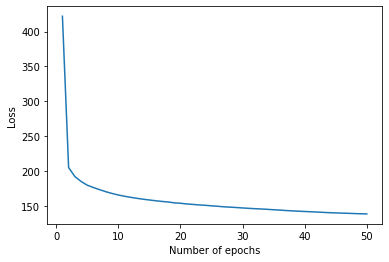

  2%|▏         | 1/50 [00:00<00:29,  1.68it/s]

EPOCH: 01/50 LOSS: 657.5454


  4%|▍         | 2/50 [00:01<00:28,  1.71it/s]

EPOCH: 02/50 LOSS: 344.8715


  6%|▌         | 3/50 [00:01<00:27,  1.72it/s]

EPOCH: 03/50 LOSS: 326.6163


  8%|▊         | 4/50 [00:02<00:27,  1.69it/s]

EPOCH: 04/50 LOSS: 312.3053


 10%|█         | 5/50 [00:02<00:26,  1.69it/s]

EPOCH: 05/50 LOSS: 310.6845


 12%|█▏        | 6/50 [00:03<00:26,  1.66it/s]

EPOCH: 06/50 LOSS: 295.3957


 14%|█▍        | 7/50 [00:04<00:25,  1.68it/s]

EPOCH: 07/50 LOSS: 293.8073


 16%|█▌        | 8/50 [00:04<00:24,  1.69it/s]

EPOCH: 08/50 LOSS: 287.0161


 18%|█▊        | 9/50 [00:05<00:24,  1.70it/s]

EPOCH: 09/50 LOSS: 283.8470


 20%|██        | 10/50 [00:05<00:23,  1.71it/s]

EPOCH: 10/50 LOSS: 280.7611


 22%|██▏       | 11/50 [00:06<00:22,  1.70it/s]

EPOCH: 11/50 LOSS: 278.1386


 24%|██▍       | 12/50 [00:07<00:22,  1.72it/s]

EPOCH: 12/50 LOSS: 274.1310


 26%|██▌       | 13/50 [00:07<00:21,  1.71it/s]

EPOCH: 13/50 LOSS: 272.5551


 28%|██▊       | 14/50 [00:08<00:20,  1.72it/s]

EPOCH: 14/50 LOSS: 270.2792


 30%|███       | 15/50 [00:08<00:20,  1.70it/s]

EPOCH: 15/50 LOSS: 268.2743


 32%|███▏      | 16/50 [00:09<00:20,  1.68it/s]

EPOCH: 16/50 LOSS: 265.5157


 34%|███▍      | 17/50 [00:10<00:19,  1.67it/s]

EPOCH: 17/50 LOSS: 263.9327


 36%|███▌      | 18/50 [00:10<00:18,  1.68it/s]

EPOCH: 18/50 LOSS: 261.3547


 38%|███▊      | 19/50 [00:11<00:18,  1.70it/s]

EPOCH: 19/50 LOSS: 259.1556


 40%|████      | 20/50 [00:11<00:17,  1.71it/s]

EPOCH: 20/50 LOSS: 256.8921


 42%|████▏     | 21/50 [00:12<00:16,  1.71it/s]

EPOCH: 21/50 LOSS: 254.4403


 44%|████▍     | 22/50 [00:12<00:16,  1.70it/s]

EPOCH: 22/50 LOSS: 252.0974


 46%|████▌     | 23/50 [00:13<00:15,  1.71it/s]

EPOCH: 23/50 LOSS: 250.0178


 48%|████▊     | 24/50 [00:14<00:14,  1.74it/s]

EPOCH: 24/50 LOSS: 248.8431


 50%|█████     | 25/50 [00:14<00:14,  1.73it/s]

EPOCH: 25/50 LOSS: 247.3643


 52%|█████▏    | 26/50 [00:15<00:13,  1.74it/s]

EPOCH: 26/50 LOSS: 246.1216


 54%|█████▍    | 27/50 [00:15<00:13,  1.72it/s]

EPOCH: 27/50 LOSS: 244.7184


 56%|█████▌    | 28/50 [00:16<00:12,  1.72it/s]

EPOCH: 28/50 LOSS: 243.6916


 58%|█████▊    | 29/50 [00:17<00:12,  1.73it/s]

EPOCH: 29/50 LOSS: 242.8496


 60%|██████    | 30/50 [00:17<00:11,  1.73it/s]

EPOCH: 30/50 LOSS: 241.9358


 62%|██████▏   | 31/50 [00:18<00:11,  1.70it/s]

EPOCH: 31/50 LOSS: 241.0898


 64%|██████▍   | 32/50 [00:18<00:10,  1.69it/s]

EPOCH: 32/50 LOSS: 240.4049


 66%|██████▌   | 33/50 [00:19<00:10,  1.67it/s]

EPOCH: 33/50 LOSS: 239.7903


 68%|██████▊   | 34/50 [00:20<00:09,  1.67it/s]

EPOCH: 34/50 LOSS: 239.0831


 70%|███████   | 35/50 [00:20<00:08,  1.67it/s]

EPOCH: 35/50 LOSS: 238.4470


 72%|███████▏  | 36/50 [00:21<00:08,  1.67it/s]

EPOCH: 36/50 LOSS: 237.6277


 74%|███████▍  | 37/50 [00:21<00:07,  1.66it/s]

EPOCH: 37/50 LOSS: 236.9034


 76%|███████▌  | 38/50 [00:22<00:07,  1.67it/s]

EPOCH: 38/50 LOSS: 236.3869


 78%|███████▊  | 39/50 [00:23<00:06,  1.66it/s]

EPOCH: 39/50 LOSS: 235.7118


 80%|████████  | 40/50 [00:23<00:06,  1.66it/s]

EPOCH: 40/50 LOSS: 235.3870


 82%|████████▏ | 41/50 [00:24<00:05,  1.64it/s]

EPOCH: 41/50 LOSS: 234.7630


 84%|████████▍ | 42/50 [00:24<00:04,  1.65it/s]

EPOCH: 42/50 LOSS: 234.3067


 86%|████████▌ | 43/50 [00:25<00:04,  1.66it/s]

EPOCH: 43/50 LOSS: 233.8118


 88%|████████▊ | 44/50 [00:26<00:03,  1.65it/s]

EPOCH: 44/50 LOSS: 233.5008


 90%|█████████ | 45/50 [00:26<00:02,  1.67it/s]

EPOCH: 45/50 LOSS: 232.9560


 92%|█████████▏| 46/50 [00:27<00:02,  1.62it/s]

EPOCH: 46/50 LOSS: 232.4660


 94%|█████████▍| 47/50 [00:27<00:01,  1.63it/s]

EPOCH: 47/50 LOSS: 232.1331


 96%|█████████▌| 48/50 [00:28<00:01,  1.64it/s]

EPOCH: 48/50 LOSS: 231.5938


 98%|█████████▊| 49/50 [00:29<00:00,  1.65it/s]

EPOCH: 49/50 LOSS: 231.3166


100%|██████████| 50/50 [00:29<00:00,  1.68it/s]

EPOCH: 50/50 LOSS: 230.9674


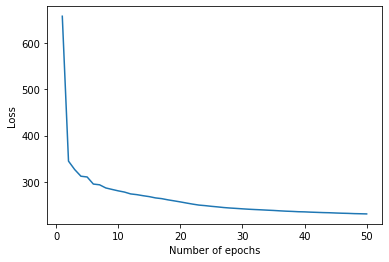

  2%|▏         | 1/50 [00:00<00:28,  1.69it/s]

EPOCH: 01/50 LOSS: 901.7352


  4%|▍         | 2/50 [00:01<00:28,  1.69it/s]

EPOCH: 02/50 LOSS: 536.1779


  6%|▌         | 3/50 [00:01<00:27,  1.72it/s]

EPOCH: 03/50 LOSS: 512.7894


  8%|▊         | 4/50 [00:02<00:26,  1.72it/s]

EPOCH: 04/50 LOSS: 498.4797


 10%|█         | 5/50 [00:02<00:25,  1.73it/s]

EPOCH: 05/50 LOSS: 490.1876


 12%|█▏        | 6/50 [00:03<00:25,  1.71it/s]

EPOCH: 06/50 LOSS: 481.5849


 14%|█▍        | 7/50 [00:04<00:24,  1.73it/s]

EPOCH: 07/50 LOSS: 475.6116


 16%|█▌        | 8/50 [00:04<00:24,  1.72it/s]

EPOCH: 08/50 LOSS: 466.4238


 18%|█▊        | 9/50 [00:05<00:24,  1.70it/s]

EPOCH: 09/50 LOSS: 457.4687


 20%|██        | 10/50 [00:05<00:23,  1.67it/s]

EPOCH: 10/50 LOSS: 449.8713


 22%|██▏       | 11/50 [00:06<00:23,  1.65it/s]

EPOCH: 11/50 LOSS: 443.4447


 24%|██▍       | 12/50 [00:07<00:22,  1.69it/s]

EPOCH: 12/50 LOSS: 436.5527


 26%|██▌       | 13/50 [00:07<00:21,  1.71it/s]

EPOCH: 13/50 LOSS: 430.5729


 28%|██▊       | 14/50 [00:08<00:20,  1.72it/s]

EPOCH: 14/50 LOSS: 423.0085


 30%|███       | 15/50 [00:08<00:20,  1.72it/s]

EPOCH: 15/50 LOSS: 417.5439


 32%|███▏      | 16/50 [00:09<00:19,  1.71it/s]

EPOCH: 16/50 LOSS: 412.9379


 34%|███▍      | 17/50 [00:10<00:22,  1.46it/s]

EPOCH: 17/50 LOSS: 409.0903


 36%|███▌      | 18/50 [00:11<00:24,  1.33it/s]

EPOCH: 18/50 LOSS: 405.7981


 38%|███▊      | 19/50 [00:11<00:21,  1.43it/s]

EPOCH: 19/50 LOSS: 402.8162


 40%|████      | 20/50 [00:12<00:19,  1.51it/s]

EPOCH: 20/50 LOSS: 400.3070


 42%|████▏     | 21/50 [00:12<00:18,  1.57it/s]

EPOCH: 21/50 LOSS: 397.4807


 44%|████▍     | 22/50 [00:13<00:17,  1.58it/s]

EPOCH: 22/50 LOSS: 395.2331


 46%|████▌     | 23/50 [00:14<00:16,  1.62it/s]

EPOCH: 23/50 LOSS: 393.2769


 48%|████▊     | 24/50 [00:14<00:15,  1.65it/s]

EPOCH: 24/50 LOSS: 391.5528


 50%|█████     | 25/50 [00:15<00:14,  1.68it/s]

EPOCH: 25/50 LOSS: 390.0091


 52%|█████▏    | 26/50 [00:15<00:14,  1.69it/s]

EPOCH: 26/50 LOSS: 388.4161


 54%|█████▍    | 27/50 [00:16<00:13,  1.69it/s]

EPOCH: 27/50 LOSS: 386.7888


 56%|█████▌    | 28/50 [00:17<00:12,  1.70it/s]

EPOCH: 28/50 LOSS: 385.2226


 58%|█████▊    | 29/50 [00:17<00:12,  1.71it/s]

EPOCH: 29/50 LOSS: 383.7873


 60%|██████    | 30/50 [00:18<00:11,  1.72it/s]

EPOCH: 30/50 LOSS: 382.4599


 62%|██████▏   | 31/50 [00:18<00:11,  1.71it/s]

EPOCH: 31/50 LOSS: 381.3776


 64%|██████▍   | 32/50 [00:19<00:10,  1.70it/s]

EPOCH: 32/50 LOSS: 380.3453


 66%|██████▌   | 33/50 [00:20<00:10,  1.67it/s]

EPOCH: 33/50 LOSS: 379.3161


 68%|██████▊   | 34/50 [00:20<00:09,  1.69it/s]

EPOCH: 34/50 LOSS: 378.3219


 70%|███████   | 35/50 [00:21<00:08,  1.70it/s]

EPOCH: 35/50 LOSS: 377.4996


 72%|███████▏  | 36/50 [00:21<00:08,  1.70it/s]

EPOCH: 36/50 LOSS: 376.6323


 74%|███████▍  | 37/50 [00:22<00:07,  1.72it/s]

EPOCH: 37/50 LOSS: 375.9333


 76%|███████▌  | 38/50 [00:22<00:07,  1.71it/s]

EPOCH: 38/50 LOSS: 375.1440


 78%|███████▊  | 39/50 [00:23<00:06,  1.73it/s]

EPOCH: 39/50 LOSS: 374.4408


 80%|████████  | 40/50 [00:24<00:05,  1.69it/s]

EPOCH: 40/50 LOSS: 373.7334


 82%|████████▏ | 41/50 [00:24<00:05,  1.70it/s]

EPOCH: 41/50 LOSS: 372.9946


 84%|████████▍ | 42/50 [00:25<00:04,  1.71it/s]

EPOCH: 42/50 LOSS: 372.3716


 86%|████████▌ | 43/50 [00:25<00:04,  1.71it/s]

EPOCH: 43/50 LOSS: 371.8317


 88%|████████▊ | 44/50 [00:26<00:03,  1.71it/s]

EPOCH: 44/50 LOSS: 371.1769


 90%|█████████ | 45/50 [00:27<00:02,  1.70it/s]

EPOCH: 45/50 LOSS: 370.7208


 92%|█████████▏| 46/50 [00:27<00:02,  1.70it/s]

EPOCH: 46/50 LOSS: 370.1211


 94%|█████████▍| 47/50 [00:28<00:01,  1.66it/s]

EPOCH: 47/50 LOSS: 369.6664


 96%|█████████▌| 48/50 [00:28<00:01,  1.65it/s]

EPOCH: 48/50 LOSS: 369.0749


 98%|█████████▊| 49/50 [00:29<00:00,  1.67it/s]

EPOCH: 49/50 LOSS: 368.5099


100%|██████████| 50/50 [00:30<00:00,  1.66it/s]

EPOCH: 50/50 LOSS: 368.1631


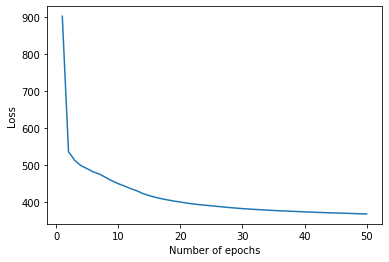

In [101]:
# prepare data
input_data, label_data_1, label_data_2, label_data_3 = data_transformation(positions_train, velocities_train, charges_train)
train_dataset_1 = MyDataset(input_data, label_data_1)
train_dataset_2 = MyDataset(input_data, label_data_2)
train_dataset_3 = MyDataset(input_data, label_data_3)

# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')
# criterion
criterion = MSELoss()
# trainer
trainer = Trainer(device=device,
                  criterion=criterion,
                  epochs=50)


# model one: using data in timpoint 0 to predict timepoint 0.5
model_1 = Network().to(device)
# optimizer
optimizer_1 = torch.optim.SGD(model_1.parameters(), lr=0.0001, momentum=0.5)
# data loader
train_loader_1 = torch.utils.data.DataLoader(train_dataset_1, batch_size=100)
# start training
trainer.run_trainer(model_1, train_loader_1, optimizer_1)

# model two: using data in timpoint 0 to predict timepoint 1
model_2 = Network().to(device)
# optimizer
optimizer_2 = torch.optim.SGD(model_2.parameters(), lr=0.0001, momentum=0.5)
# data loader
train_loader_2 = torch.utils.data.DataLoader(train_dataset_2, batch_size=100)
# start training
trainer.run_trainer(model_2, train_loader_2, optimizer_2)

# model three: using data in timpoint 0 to predict timepoint 1.5
model_3 = Network().to(device)
# optimizer
optimizer_3 = torch.optim.SGD(model_3.parameters(), lr=0.0001, momentum=0.5)
# data loader
train_loader_3 = torch.utils.data.DataLoader(train_dataset_3, batch_size=100)
# start training
trainer.run_trainer(model_3, train_loader_3, optimizer_3)



# Evaluation

In [ ]:
#todo

In [102]:
# prepare test data
input_data, label_data_1, label_data_2, label_data_3 = data_transformation(positions_test, velocities_test, charges_test)
test_dataset_1 = MyDataset(input_data, label_data_1)
test_dataset_2 = MyDataset(input_data, label_data_2)
test_dataset_3 = MyDataset(input_data, label_data_3)
# data loader
test_DataLoader_1 = torch.utils.data.DataLoader(test_dataset_1, batch_size=100)
test_DataLoader_2 = torch.utils.data.DataLoader(test_dataset_2, batch_size=100)
test_DataLoader_3 = torch.utils.data.DataLoader(test_dataset_3, batch_size=100)

In [103]:
# evaluation model1
trainer.evaluation(model_1, test_DataLoader_1)
# evaluation model2
trainer.evaluation(model_2, test_DataLoader_2)
# evaluation model3
trainer.evaluation(model_3, test_DataLoader_3)

ACCURACY: 0.9745
ACCURACY: 0.9614
ACCURACY: 0.9458
